In [1]:
!pip install -U layoutparser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-6dfnjl2w/detectron2_72114d5c373a40669808bc65fca875d7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-6dfnjl2w/detectron2_72114d5c373a40669808bc65fca875d7
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Preparing metadata (setup.py) ... done


In [3]:
!pip install layoutparser[ocr]     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!git clone https://github.com/Layout-Parser/layout-parser.git

fatal: destination path 'layout-parser' already exists and is not an empty directory.


In [6]:
%cd layout-parser/

/content/layout-parser


In [8]:
import cv2
image = cv2.imread("/content/layout-parser/examples/data/bank4.jpg")
image = image[..., ::-1] 

config.yml?dl=1: 8.19kB [00:01, 6.37kB/s]
model_final.pth?dl=1: 330MB [00:05, 56.3MB/s]                           
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


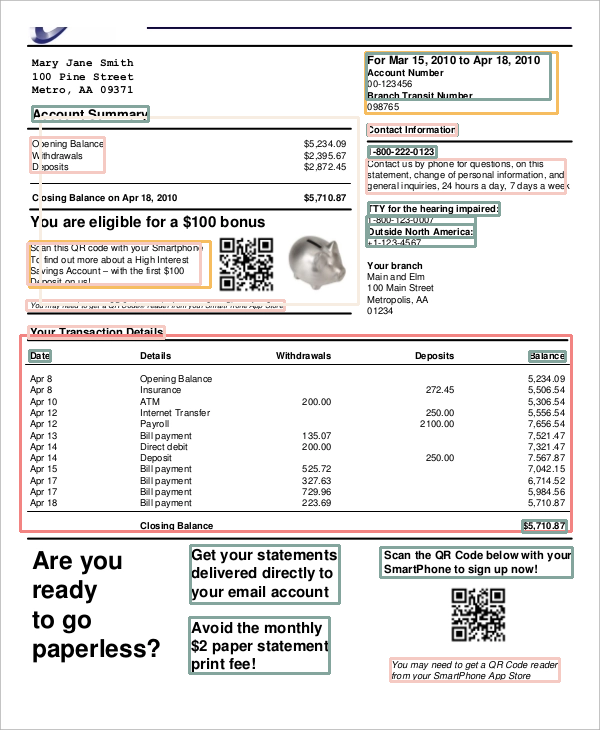

In [9]:
import layoutparser as lp
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.30],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
layout = model.detect(image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
lp.draw_box(image, layout,)

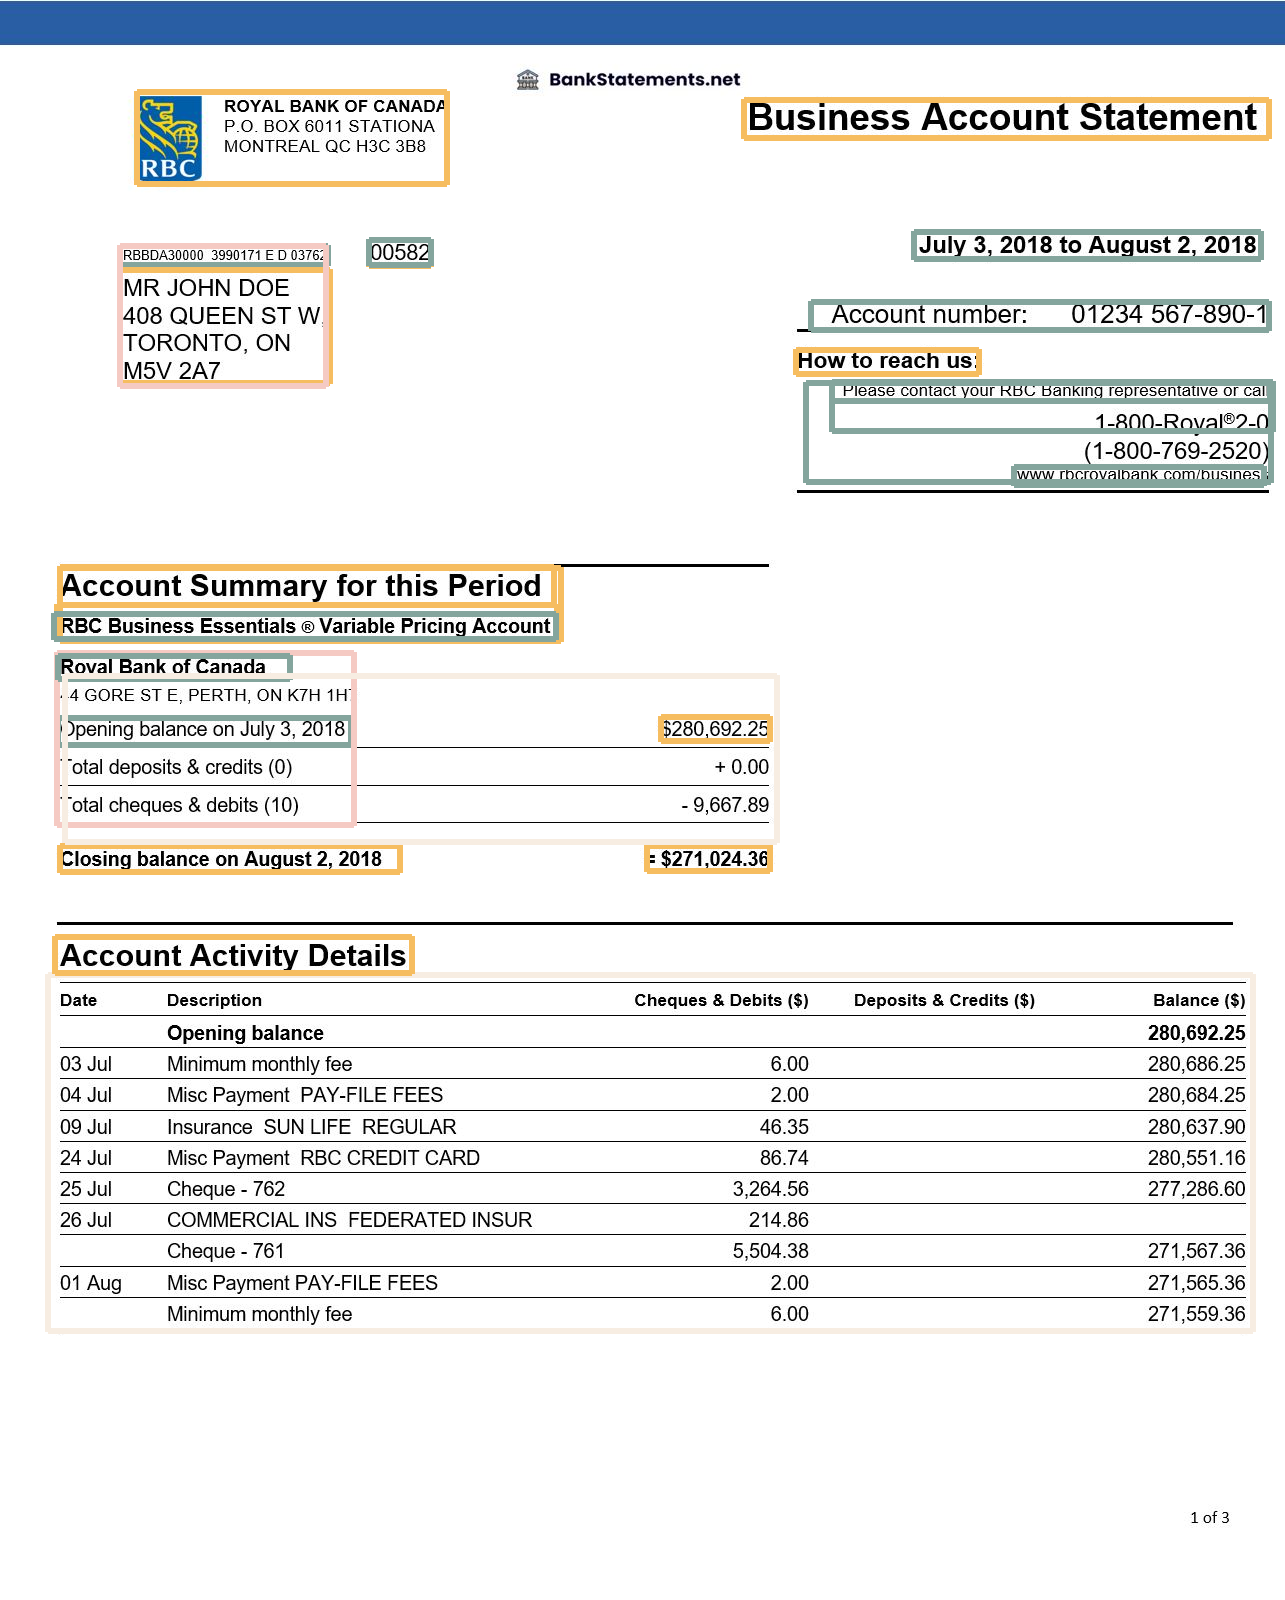

In [43]:

model1 = lp.Detectron2LayoutModel('lp://TableBank/faster_rcnn_R_101_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.30],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
layout1 = model.detect(image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
lp.draw_box(image, layout,)

In [10]:
text_blocks = lp.Layout([b for b in layout if b.type=="Text"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=26.60284423828125, y_1=300.9286804199219, x_2=284.9925842285156, y_2=310.21673583984375), text=None, id=None, type=Text, parent=None, next=None, score=0.9961910247802734), TextBlock(block=Rectangle(x_1=366.74560546875, y_1=159.01824951171875, x_2=565.1978759765625, y_2=193.02700805664062), text=None, id=None, type=Text, parent=None, next=None, score=0.941830039024353), TextBlock(block=Rectangle(x_1=390.4904479980469, y_1=658.7838134765625, x_2=559.2808837890625, y_2=681.5785522460938), text=None, id=None, type=Text, parent=None, next=None, score=0.8795680999755859), TextBlock(block=Rectangle(x_1=368.7584533691406, y_1=124.4424057006836, x_2=456.2837219238281, y_2=135.7329559326172), text=None, id=None, type=Text, parent=None, next=None, score=0.6460542678833008), TextBlock(block=Rectangle(x_1=30.563522338867188, y_1=137.64842224121094, x_2=104.98110961914062, y_2=172.25244140625), text=None, id=None, type=Text, parent=None, next=None, score

In [15]:
title_blocks = lp.Layout([b for b in layout if b.type=='Title'])
list_blocks = lp.Layout([b for b in layout if b.type=='List'])
table_blocks = lp.Layout([b for b in layout if b.type=='Table'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [38]:
valdation_block=title_blocks;


In [34]:
filter_expresion = lp.Layout([b for b in valdation_block ])

In [39]:

filter_expresion = lp.Layout([b for b in valdation_block \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [40]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = filter_expresion.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in filter_expresion if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
test_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

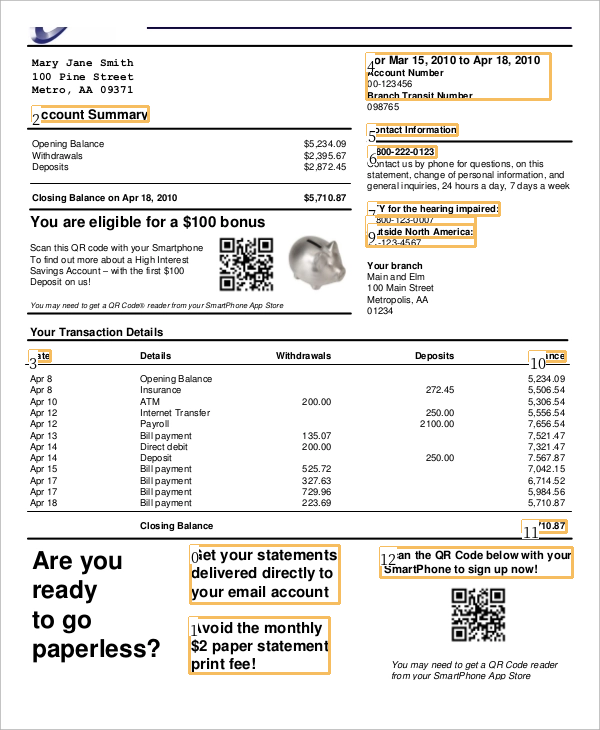

In [41]:

lp.draw_box(image, test_blocks,
            box_width=3, 
            show_element_id=True)

In [27]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [ ]:
!sudo apt install tesseract-ocr


In [28]:
for block in test_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [29]:
for txt in test_blocks.get_texts():
    print(txt, end='\n---\n')

 

 

 

bate
Data
oe Wiherowa
a ‘Opening Balance =
a ‘aware sa
Agr 12 tne
Aerie Intemet Transter 200.00 oes Se
fee fyot Se
Apri Billpayment ‘8 Be
Apri Direct debit a ame ee
= a se esos
fee Btpayment ae
Aeni7 Billpayment cea oe co
AB Billpayment Soe Ee
Billpayment pose ie
28 erase
‘Closing Batonce aa
Smoay
‘ssri087

---


In [ ]:
text_blocks.get_texts()

In [ ]:
for block in text_blocks:
  print(block)

In [ ]:
!pip install spacy

In [ ]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

In [ ]:
!pip install click==7.1.1

In [ ]:
import spacy
nlp = spacy.load("en_core_web_trf")


In [ ]:
sentence=["".join(txt) for txt in text_blocks.get_texts()]

In [ ]:
".".join(sentence)  

In [ ]:
doc = nlp(".".join(sentence))
for ent in doc.ents:
  print(ent.text,ent.label_)